#Neste notebook irei reestimar os parâmetros ternários do modelo de Wilson para o sistema Acetona-Metanol_Água, mas usando como parâmetros iniciais (a_W) os parâmetros binários, não do livro (SVNA), mas os já estimados nos notebooks anteriores usando o cálculo do $\Phi$ usando os modelos de equações de estado (Van Der Waals, RK, SRK e Peng-Robinson) e não o  $\Phi$ genérico.

##Assim será verificada a influência da estimação mais rigorosa dos parâmetros binários na estimação dos parâmetros ternários.

In [1]:
# Preparando kernel
import numpy as np
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Montando o Google drive
from google.colab import drive
drive.mount('/content/drive')
# Para ler/carregar
#path = '/content/drive/MyDrive/Operações 3/'
path = '/content/drive/MyDrive/PFG_Mateus_Ferreira/'
#path = '/content/drive/MyDrive/Classroom/OpUnit3_files/OU3_Python/'
with open(path + 'databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)
print(dados.shape)
# Incluindo uma pasta do drive (mounted) no path do COLAB
import sys
sys.path.append(path)
# Carregamento das funções úteis
from OU3_funcoes_uteis_v05_2 import *
import TEQ_funcoes_uteis_v06 as teq
import OU3_funcoes_uteis_v05_2 as ou3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(468, 31)


In [3]:
# Para procurar o 'num' de um determinado componente pelo nome
dados[dados.name.str.contains('water', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,...,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
466,20,WATER,18.015,273.2,373.2,647.3,217.6,56.0,0.229,0.344,...,18.3036,3816.44,-46.13,441.0,284.0,55.336,-6869.5,-5.115,1.05,9717.0


In [4]:
# Seleção dos componentes presentes no sistema
lista_componentes = [122, 62, 20]
nc = len(lista_componentes)
nc

3

In [5]:
dados[dados['num'].isin(lista_componentes)][['num','name']]

,num,name
145,122,ACETONE
296,62,METHANOL
466,20,WATER


In [6]:
# Verificando os pontos de ebulição de nossos componentes
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[329.4, 337.8, 373.2]

##Inserindo na célula abaixo os valores de a_W estimados para os sistemas binários anteriormente, mas agora utilizando o $\Phi$ das equações de estado (EOS) e não o $\Phi$ genérico.

In [7]:
# Valores do a_W - Estimados
# acetona = 1
# metanol = 2
# água    = 3
nc = 3
a_W = np.zeros((nc,nc))
# acetona e água - Sistema binário 1
a_W[1-1,3-1] = 2133.10886232
a_W[3-1,1-1] = -373.16047751
# metanol e água - Sistema binário 3
a_W[2-1,3-1] = 1272.61896714
a_W[3-1,2-1] = -397.11108971
# acetona e metanol - Sistema binário 2
a_W[1-1,2-1] = 710.66000503
a_W[2-1,1-1] = -278.05542082
#
a_W

array([[   0.        ,  710.66000503, 2133.10886232],
       [-278.05542082,    0.        , 1272.61896714],
       [-373.16047751, -397.11108971,    0.        ]])

In [8]:
V_m = f_Vol_molar_db(lista_componentes, dados)
V_m

array([73.51898734, 40.50821745, 18.0511022 ])

In [9]:
#Composição do sistema
z = np.array([0.1,0.2,0.7])

In [10]:
#Estabelecendo uma pressão de equilíbrio
P_eq = 101.33*(760.0/101.325) # mmHg
P_eq

760.0375030841352

In [11]:
#Definindo a função que calcula a temperatura do ponto de bolha usando o PHI GENÉRICO
#
def f_calc_T_Pb_nid_Wilson_01_db(z, P_eq, a_W, V_m, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
  '''
  nc = z.shape[0]
  resp = f_calculo_PbPo_db('T', P_eq, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = f_sol_RR_flash_db(z, P_eq, T_pb, lista_componentes, dados)['y_eq']
  K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, a_W, V_m, 
                                       lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
  gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = 2
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = f_Teq_Antoine_db(Pvap_novo, lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    #print(k_iter, np.abs(erro_T).mean())
    K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, 
                                       a_W, V_m, lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
    gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator = x_eq*gama_comp/phi_comp
    Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
    T_pb_novo = np.zeros((nc,))
    for j in range(0,nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = f_Teq_Antoine_db(Pvap_novo, lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

##**Inserindo as funções necessárias para se calcular o BOL_T por Wilson usando $\Phi$ das equações de estado (EOS): Van der Waals, RK, SRK e Peng - Robinson.**

In [12]:
def f_K_Wilson_phi_EOS(x, y, T, P, a_W, V_m, i_EOS, lista_componentes, dados):
  nc = x.shape[0]
  # Função para o cálculo do phi
  phi_comp  = f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados)['phi']
  # Para o cálculo do gama
  gama_comp = f_gama_Wilson(x, T, a_W, V_m)
  # Cálculo de P_vap
  Pvap_comp = f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)
  Pvap_comp_bar = Pvap_comp *(1.0133/760.0)
  # Cálculo do K
  K = np.zeros((nc,))
  for i in range(0,nc):
    K[i] = (Pvap_comp_bar[i]*gama_comp[i])/(P*phi_comp[i])
  #
  return K

In [13]:
def f_fator_Poynting(T, P, lista_componentes, dados):
  ''' Calcula o fator de correção de Poynting segundo a Eq. 11.44 p.297
  '''
  nc = len(lista_componentes)
  R_ig = 83.14 # bar*cm3/mol/K
  V_m = f_Vol_molar_db(lista_componentes, dados)
  Pvap_comp = f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)*(1.01325/760.0)
  fatPoy = np.zeros((nc,))
  for i in range(0,nc):
    num       = V_m[i]*(P - Pvap_comp[i])
    den       = R_ig*T
    fatPoy[i] = np.exp(-num/den)
  return fatPoy

In [14]:
def f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados):
    #nc   = y.shape[0]
    R_ig = 83.14 # bar*cm3/mol/K
    # Obtendo: Tc, Pc_ omega
    Tc_comp = dados[dados['num'].isin(lista_componentes)]['critical_temp'].to_numpy()
    Pc_comp = dados[dados['num'].isin(lista_componentes)]['critical_pressure'].to_numpy()*(1.0133/1.0)
    om_comp = dados[dados['num'].isin(lista_componentes)]['acentric_factor'].to_numpy()
    #
    resp_EOS     = teq.f_calc_param_EOS_mistura(i_EOS, y, T, P, Tc_comp, 
                                                Pc_comp, om_comp, R_ig)
    param_EOS    = resp_EOS['param_EOS']
    param_cubica = teq.f_conv_param(param_EOS)
    Z_all        = teq.f_raizes_cubica(param_cubica)['x']
    Z_v          = np.max(Z_all)
    a_EOS        = resp_EOS['a_comp']
    b_EOS        = resp_EOS['b_comp']
    phi_chapeu   = teq.f_phi_chapeu_EOS_eq_14_50(Z_v, T, P, R_ig, a_EOS, 
                                                 b_EOS, y, param_EOS)
    #
    phi_sat      = teq.f_phi_sat_comp(T, i_EOS, lista_componentes, dados)
    #
    fatPoy = f_fator_Poynting(T, P, lista_componentes, dados)
    #
    phi = (phi_chapeu/phi_sat)*fatPoy
    return {'phi': phi, 'phi_chapeu': phi_chapeu, 'phi_sat': phi_sat,
            'fatPoy': fatPoy }

In [15]:
def f_K_Wilson_phi_EOS(x, y, T, P, a_W, V_m, i_EOS, lista_componentes, dados):
  nc = x.shape[0]
  # Função para o cálculo do phi
  phi_comp  = f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados)['phi']
  # Para o cálculo do gama
  gama_comp = ou3.f_gama_Wilson(x, T, a_W, V_m)
  # Cálculo de P_vap
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)
  Pvap_comp_bar = Pvap_comp *(1.0133/760.0)
  # Cálculo do K
  K = np.zeros((nc,))
  for i in range(0,nc):
    K[i] = (Pvap_comp_bar[i]*gama_comp[i])/(P*phi_comp[i])
  #
  return K

In [16]:
def f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq, a_W, V_m, i_EOS, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
      K calculado utilizando a abordagem gamma/phi com:
      gamma: modelo de Wilson
      phi:   calculado com as equações do capítulo 14 usando a razão
             phi_chapeu/phi_sat
  '''
  nc = z.shape[0]
  # Cálculo do ELV usando Raoult - sistema ideal
  P_eq_mmHg = P_eq*(760.0/1.01325)
  resp = ou3.f_calculo_PbPo_db('T', P_eq_mmHg, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = ou3.f_sol_RR_flash_db(z, P_eq_mmHg, T_pb, lista_componentes, dados)['y_eq']
  # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq, a_W, V_m, 
  #                                      lista_componentes, dados)
  K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq, a_W, V_m, i_EOS, 
                              lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  #phi_comp = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
  phi_comp = f_phi_ELV_EOS(T_pb, P_eq, y_eq_novo, i_EOS, 
                           lista_componentes, dados)['phi']
  gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = nc - 1
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)*(1.01325/760.0)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325), 
                                   lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    print(k_iter, np.abs(erro_T).mean())
    # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq, 
    #                                    a_W, V_m, lista_componentes, dados)
    K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq, a_W, V_m, i_EOS, 
                              lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    #phi_comp  = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
    phi_comp = f_phi_ELV_EOS(T_pb, P_eq, y_eq_novo, i_EOS, 
                             lista_componentes, dados)['phi']
    gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator     = x_eq*gama_comp/phi_comp
    Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, 
                                            dados)*(1.01325/760.0)
    T_pb_novo = np.zeros((nc,))
    #
    for j in range(0,nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325), 
                                          lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

##**Fim das funções necessárias para o cáculo de BOL_T**

In [17]:
#Definindo um i_EOS (índice da equação de estado que será utilizada no cálculo do Phi):
i_EOS = 3 #(3 == SRK)

In [18]:
#Definindo um pressão de quilíbrio em bar, convertendo a P_eq
P_eq_bar = P_eq*(1.01325/760) #bar
P_eq_bar

1.0132999999999999

In [19]:
sol_T_Pb = f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq, a_W, V_m, i_EOS, lista_componentes, dados)
sol_T_Pb

1 21.335760733083134
2 9.831881534764534
3 4.8618788928819185
4 2.4805892947471193
5 1.2839556755591275
6 0.6692557358099975
7 0.3500813993482552
8 0.18345665928654853
9 0.09622905785897728
10 0.05050006347710223
11 0.026508735797506233
12 0.013916963604515331
13 0.007306856697823605
14 0.003836478420566891
15 0.0020143891131283453
16 0.0010576900049272808


{'T_pb': 741.7874810518864,
 'y_eq': array([0.09899876, 0.31156079, 0.58949418]),
 'erro_T': 0.0005553614885229763}

In [20]:
caminho = '/content/drive/MyDrive/PFG_Mateus_Ferreira/'
#caminho = '/content/drive/MyDrive/PFG_EQ/PFG_Mateus_Ferreira/'
arquivo_excel = 'Dados_validacao_Bolha_T_Wilson.xlsx'
df = pd.read_excel(caminho+arquivo_excel)
df.head()

,T [K],x1 [mol/mol],x2 [mol/mol],y1 [mol/mol],y2 [mol/mol]
0,345.95,0.0188,0.3778,0.0912,0.6450
1,340.65,0.0253,0.6722,0.0773,0.7869
2,342.35,0.0331,0.5564,0.0953,0.7191
3,337.35,0.0429,0.8710,0.0945,0.8710
4,337.55,0.0449,0.8439,0.1018,0.8496


In [21]:
#Tamanho do Data Frame:
df.shape

(54, 5)

In [22]:
#Trocando o nome das colunas para facilitar:
#
df['x1'] = df.pop('x1\xa0[mol/mol]')
df['x2'] = df.pop('x2\xa0[mol/mol]')
df['y1'] = df.pop('y1\xa0[mol/mol]')
df['y2'] = df.pop('y2\xa0[mol/mol]')  
#
df.head()

,T [K],x1,x2,y1,y2
0,345.95,0.0188,0.3778,0.0912,0.6450
1,340.65,0.0253,0.6722,0.0773,0.7869
2,342.35,0.0331,0.5564,0.0953,0.7191
3,337.35,0.0429,0.8710,0.0945,0.8710
4,337.55,0.0449,0.8439,0.1018,0.8496


In [23]:
#Inserindo as colunas com os valores de x3 e y3
df['x3'] =  1 - (df['x1'] + df['x2'])
df['y3'] =  1 - (df['y1'] + df['y2'])
#
#Reordenando as colunas do Data Frame
df = df[['T [K]','x1', 'x2', 'x3', 'y1', 'y2', 'y3']]
df.head()

,T [K],x1,x2,x3,y1,y2,y3
0,345.95,0.0188,0.3778,0.6034,0.0912,0.6450,0.2638
1,340.65,0.0253,0.6722,0.3025,0.0773,0.7869,0.1358
2,342.35,0.0331,0.5564,0.4105,0.0953,0.7191,0.1856
3,337.35,0.0429,0.8710,0.0861,0.0945,0.8710,0.0345
4,337.55,0.0449,0.8439,0.1112,0.1018,0.8496,0.0486


In [24]:
a_W

array([[   0.        ,  710.66000503, 2133.10886232],
       [-278.05542082,    0.        , 1272.61896714],
       [-373.16047751, -397.11108971,    0.        ]])

In [25]:
par = np.array([2133.10886232, -373.16047751, 1272.61896714, -397.11108971, 710.66000503, -278.05542082]) #Parâmetros estimados com Phi das EOS
#par = np.array([2110.10963894, -352.2639344, 1257.02281359, -398.98898724, 703.93084504, -271.24825215]) #Parâmetros estimados com Phi genérico
#par = np.array([350.0, 1448.01, 107.38, 469.55, -161.88, 583.11])
par

array([2133.10886232, -373.16047751, 1272.61896714, -397.11108971,
        710.66000503, -278.05542082])

In [26]:
df.loc[0,'T [K]']

345.95

##**Muita atenção!** a função f_calc_T_Pb_nid_Wilson_EOS_db utiliza a pressão de equilíbrio em BAR e não em mmHg

In [41]:
def f_res_par(par, P_eq_bar, V_m, lista_componentes, dados, df):
  '''
    Entradas:
      df: dataframe com os dados experimentais para a estimação
    Saidas:

  '''
  nc = 3
  a_W = np.zeros((nc,nc))
  #
  a_W[1-1,3-1] = par[0]
  a_W[3-1,1-1] = par[1]
  # metanol e água
  a_W[2-1,3-1] = par[2]
  a_W[3-1,2-1] = par[3]
  # acetona e metanol
  a_W[1-1,2-1] = par[4]
  a_W[2-1,1-1] = par[5]
  #
  composicoes = df[['x1', 'x2', 'x3']]
  x1 = composicoes['x1'].tolist()
  x2 = composicoes['x2'].tolist()
  x3 = composicoes['x3'].tolist()
  z = np.array(list(zip(x1, x2, x3)))
  #
  n_exp = df.shape[0]
  res_T = np.zeros((n_exp,))
  res_y1 = np.zeros((n_exp,))
  res_y2 = np.zeros((n_exp,))
  res_y3 = np.zeros((n_exp,))
  for k in range(0,n_exp):
    #print(k)
    sol_T_Pb  = f_calc_T_Pb_nid_Wilson_EOS_db(z[k], P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)   #usando Phi EOS - Pressão em BAR
    #sol_T_Pb = f_calc_T_Pb_nid_Wilson_01_db(z[k], P_eq, a_W, V_m, lista_componentes, dados)              #Usando o Phi genérico - Pressão em mmHg
    res_T[k]  = df.loc[k,'T [K]'] - sol_T_Pb['T_pb']
    res_y1[k] = df.loc[k,'y1'] - sol_T_Pb['y_eq'][0]
    res_y2[k] = df.loc[k,'y2'] - sol_T_Pb['y_eq'][1]
    res_y3[k] = df.loc[k,'y3'] - sol_T_Pb['y_eq'][2]
  #
  #res = np.zeros((n_exp,))
  res = np.abs(res_T) + np.abs(res_y1) + np.abs(res_y2) + np.abs(res_y3)
  return (res)

In [42]:
%%capture
res = f_res_par(par, P_eq_bar, V_m, lista_componentes, dados, df)

In [43]:
res

array([1.74530451, 0.61116951, 1.50152335, 0.31358549, 0.32362653,
       1.65928648, 2.09301494, 1.36482467, 0.65548184, 0.50620014,
       1.52403355, 2.04127264, 1.86831168, 0.44764322, 0.19044072,
       1.05193598, 1.45018471, 1.59742333, 0.08897236, 1.42628649,
       1.17054733, 1.19640413, 1.35372186, 0.22132475, 0.61339514,
       0.72725661, 1.15647005, 0.5495538 , 0.81844817, 0.9015922 ,
       1.40421833, 0.93832091, 0.11334571, 0.24901034, 0.0539545 ,
       1.14761233, 0.51335552, 0.58955601, 0.80961165, 0.53670989,
       0.1934607 , 0.21268374, 0.08038136, 0.11879954, 0.17962676,
       0.05726753, 0.06921474, 0.21092871, 0.25671104, 0.23465358,
       0.17707233, 0.12856901, 0.51146147, 0.06731598])

##**Otimizando os parâmetros:**

###OBS: levou 39 minutos para executar

In [44]:
%%capture
from scipy.optimize import least_squares
# resp = least_squares(f_res_par, par, args=(P_eq, V_m, lista_componentes, dados, df))
resp = least_squares(f_res_par, par, method = 'lm',
                     args=(P_eq_bar, V_m, lista_componentes, dados, df))

In [45]:
resp

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.839e-01  3.559e-01 ...  4.494e-01  1.418e-01]
           x: [ 2.278e+03 -3.258e+02  7.496e+03 -8.167e+02  7.843e+02
               -3.113e+02]
        cost: 2.4224260207922916
         jac: [[-7.236e-04 -6.089e-04 ... -2.358e-03 -2.757e-03]
               [-2.067e-04 -2.171e-04 ... -2.475e-03 -2.440e-03]
               ...
               [-3.379e-04 -2.037e-03 ... -1.270e-03 -2.259e-03]
               [ 2.699e-04  1.711e-03 ...  9.498e-04  1.703e-03]]
        grad: [ 2.878e-05  6.628e-05 -1.905e-07  5.309e-05 -1.601e-04
               -1.490e-04]
  optimality: 0.00016009300591116044
 active_mask: [0 0 0 0 0 0]
        nfev: 120
        njev: None

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.839e-01  3.559e-01 ...  4.494e-01  1.418e-01]
           x: [ 2.278e+03 -3.258e+02  7.496e+03 -8.167e+02  7.843e+02
               -3.113e+02]
        cost: 2.4224260207922916
         jac: [[-7.236e-04 -6.089e-04 ... -2.358e-03 -2.757e-03]
               [-2.067e-04 -2.171e-04 ... -2.475e-03 -2.440e-03]
               ...
               [-3.379e-04 -2.037e-03 ... -1.270e-03 -2.259e-03]
               [ 2.699e-04  1.711e-03 ...  9.498e-04  1.703e-03]]
        grad: [ 2.878e-05  6.628e-05 -1.905e-07  5.309e-05 -1.601e-04
               -1.490e-04]
  optimality: 0.00016009300591116044
 active_mask: [0 0 0 0 0 0]
        nfev: 120
        njev: None

In [46]:
#Parâmetros não otimizados
par

array([2133.10886232, -373.16047751, 1272.61896714, -397.11108971,
        710.66000503, -278.05542082])

In [47]:
#Parâmetros ótimos
par_opt = resp.x
par_opt

array([2278.40831976, -325.76654876, 7495.85103856, -816.68226571,
        784.31914628, -311.31593049])

##Parâmetros ótimos obtidos: $([2278.40831976, -325.76654876, 7495.85103856, -816.68226571, 784.31914628, -311.31593049])$

###Houve uma grande mudança em dois parâmetros em específico que são os de interação do metanol com a água, que um mudou de $1272.61896714$ para $7495.85103856$ e o outro de $-397.11108971$ para $-816.68226571$, mostrando grande sensibilidade.

In [48]:
#Calculando os resíduos (que devem ser os menores possíveis) utilizando os parâmetros ótimos 
%%capture
res_opt = f_res_par(par_opt, P_eq_bar, V_m, lista_componentes, dados, df)

In [49]:
#Resíduos usando os parâmetros ótimos
res_opt

array([0.18394172, 0.35589189, 0.2081617 , 0.15665786, 0.08820565,
       0.52034074, 0.91947649, 0.09670555, 0.17849165, 0.22061845,
       0.16874524, 0.06694827, 0.2783252 , 0.30765948, 0.02531841,
       0.49207208, 0.15975858, 0.21219434, 0.11793173, 0.14814881,
       0.15972261, 0.17696491, 0.14265788, 0.11777441, 0.13724254,
       0.31231773, 0.04493202, 0.16390682, 0.08566652, 0.60169892,
       0.65521698, 0.22190198, 0.03881663, 0.44941083, 0.10848898,
       0.60694054, 0.09171708, 0.07765548, 0.53381765, 0.46229227,
       0.06945442, 0.29921964, 0.12422691, 0.08849499, 0.13555177,
       0.19468874, 0.15506649, 0.2699826 , 0.2628964 , 0.26571147,
       0.1758    , 0.06224203, 0.44937977, 0.14182981])

In [50]:
#Resíduos usando os parâmetros não ótimos, a fim de compara ambos
res

array([1.74530451, 0.61116951, 1.50152335, 0.31358549, 0.32362653,
       1.65928648, 2.09301494, 1.36482467, 0.65548184, 0.50620014,
       1.52403355, 2.04127264, 1.86831168, 0.44764322, 0.19044072,
       1.05193598, 1.45018471, 1.59742333, 0.08897236, 1.42628649,
       1.17054733, 1.19640413, 1.35372186, 0.22132475, 0.61339514,
       0.72725661, 1.15647005, 0.5495538 , 0.81844817, 0.9015922 ,
       1.40421833, 0.93832091, 0.11334571, 0.24901034, 0.0539545 ,
       1.14761233, 0.51335552, 0.58955601, 0.80961165, 0.53670989,
       0.1934607 , 0.21268374, 0.08038136, 0.11879954, 0.17962676,
       0.05726753, 0.06921474, 0.21092871, 0.25671104, 0.23465358,
       0.17707233, 0.12856901, 0.51146147, 0.06731598])

##Criando uma função que lê uma lista de listas de composições de misturas ternárias e calcula o bolha T para elas:

In [51]:
def calcular_ponto_bolha_3_componentes(composicoes, P_eq, a_W, V_m, i_EOS, lista_componentes, dados):
    '''função que calcula a temperatura do ponto de bolha e a composição da fase vapor para uma mistura de componentes e
    armazena os valores em um Data Frame chamado df_resultados.
    z é a lista (ou lista de listas) da composição da fase líquida e P_eq é a pressão de equilíbrio do sistema'''
    resultados = []
    for composicao in composicoes:
        # Chame a função que realiza o cálculo da temperatura do ponto de bolha
        # e da composição da fase vapor com base na composição da mistura e na pressão do sistema
        T_pb_Wilson             = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
        y1_Wilson               = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq'][0]
        y2_Wilson               = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq'][1]
        y3_Wilson               = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq'][2]
        
        # Adicione os resultados em uma lista como tuplas
        resultados.append((composicao, T_pb_Wilson, y1_Wilson, y2_Wilson, y3_Wilson))
    
    # Criando um DataFrame a partir da lista de resultados
    df_resultados = pd.DataFrame(resultados, columns=["Composição", "T_pb_Wilson", "y1_Wilson", "y2_Wilson", "y3_Wilson"])
    
    return df_resultados

In [52]:
#Transformando os dados de entrada do que estão no Data Frame em uma lista de listas onde cada lista interna contém os valores de fração molar
# de cada componente
x1 = df['x1'].tolist()
x2 = df['x2'].tolist()
x3 = df['x3'].tolist()
lista_composicoes = np.array(list(zip(x1, x2, x3)))
lista_composicoes[0:5]

array([[0.0188, 0.3778, 0.6034],
       [0.0253, 0.6722, 0.3025],
       [0.0331, 0.5564, 0.4105],
       [0.0429, 0.871 , 0.0861],
       [0.0449, 0.8439, 0.1112]])

In [55]:
#Criando o Data Frame com os resultados calculados por Wilson:
#O comando CAPTURE é para suprimir a saída da célula para poupar espaço, mas ele também impede a célula de exibir uma mensagem de erro 
%%capture
resultado = calcular_ponto_bolha_3_componentes(lista_composicoes, P_eq, a_W, V_m, i_EOS, lista_componentes, dados)

In [56]:
resultado

,Composição,T_pb_Wilson,y1_Wilson,y2_Wilson,y3_Wilson
0,"[0.0188, 0.3778, 0.6033999999999999]",344.252425,0.093765,0.666331,0.239967
1,"[0.0253, 0.6722, 0.3025]",340.039099,0.077284,0.786810,0.135963
2,"[0.0331, 0.5564, 0.4105]",340.884152,0.113169,0.716503,0.170390
3,"[0.0429, 0.871, 0.08609999999999995]",337.068952,0.100649,0.854777,0.044665
4,"[0.0449, 0.8439, 0.11119999999999997]",337.252213,0.107032,0.836709,0.056316
5,"[0.0628, 0.3042, 0.633]",341.617681,0.274289,0.504325,0.221447
6,"[0.0639, 0.1166, 0.8195]",343.908796,0.426690,0.294936,0.278435
7,"[0.0724, 0.4985, 0.42910000000000004]",339.296597,0.223353,0.611859,0.164872
8,"[0.0757, 0.715, 0.20930000000000004]",337.196171,0.182208,0.723367,0.094493
9,"[0.084, 0.0401, 0.8759]",343.297498,0.601113,0.115196,0.283782


##Agora tendo os valores calculados por Wilson e aqueles experimentais presentes no conjunto de dados faz-se um comparativo entre ambos

#Fazendo uma análise gráfica dos resultados por uma reta de referência em relação a cada uma das variáveis de reposta: $T_{pb}$, $y_1, y_2$ e $y_3$


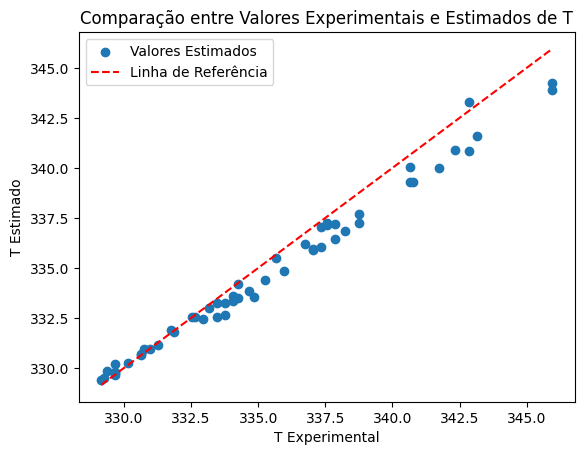

In [57]:
import matplotlib.pyplot as plt

# Criando um gráfico de dispersão com linha de regressão para T

plt.scatter(df['T [K]'], resultado['T_pb_Wilson'], label='Valores Estimados')
plt.plot([df['T [K]'].min(), df['T [K]'].max()], [df['T [K]'].min(), df['T [K]'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('T Experimental')
plt.ylabel('T Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de T')
plt.legend()
plt.show()

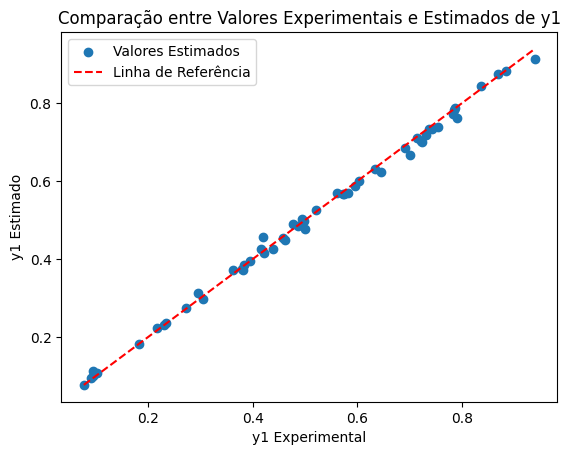

In [59]:
# Criando um gráfico de dispersão com linha de regressão para y1

plt.scatter(df['y1'], resultado['y1_Wilson'], label='Valores Estimados')
plt.plot([df['y1'].min(), df['y1'].max()], [df['y1'].min(), df['y1'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y1 Experimental')
plt.ylabel('y1 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y1')
plt.legend()
plt.show()

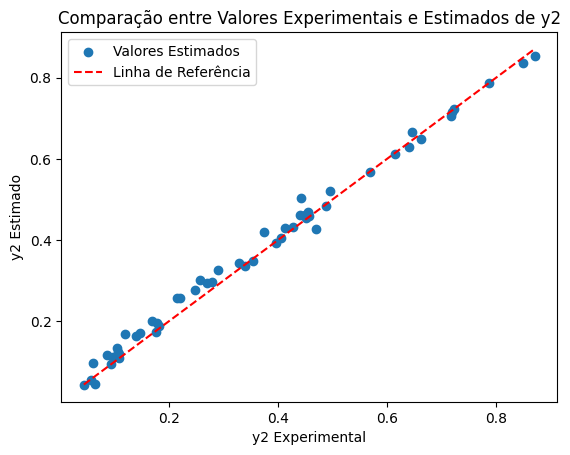

In [60]:
# Criando um gráfico de dispersão com linha de regressão para y2

plt.scatter(df['y2'], resultado['y2_Wilson'], label='Valores Estimados')
plt.plot([df['y2'].min(), df['y2'].max()], [df['y2'].min(), df['y2'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y2 Experimental')
plt.ylabel('y2 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y2')
plt.legend()
plt.show()

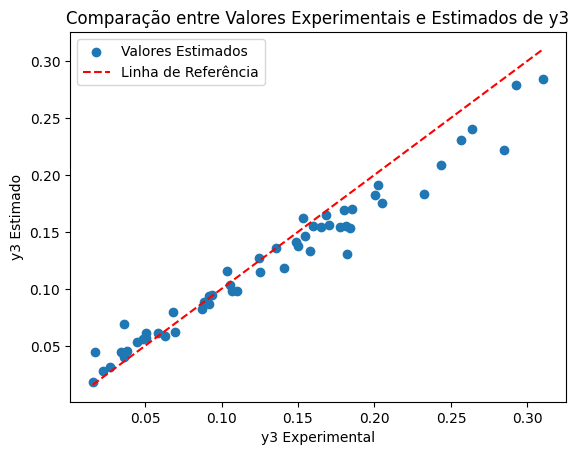

In [61]:
# Criando um gráfico de dispersão com linha de regressão para y3

plt.scatter(df['y3'], resultado['y3_Wilson'], label='Valores Estimados')
plt.plot([df['y3'].min(), df['y3'].max()], [df['y3'].min(), df['y3'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y3 Experimental')
plt.ylabel('y3 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y3')
plt.legend()
plt.show()

In [62]:
# Importando o pacote com as figuras de mérito para avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [63]:
# Calculando o erro médio absoluto (MAE)
mae_T = mean_absolute_error(df['T [K]'], resultado['T_pb_Wilson'])
mae_y1 = mean_absolute_error(df['y1'], resultado['y1_Wilson'])
mae_y2 = mean_absolute_error(df['y2'], resultado['y2_Wilson'])
mae_y3 = mean_absolute_error(df['y3'], resultado['y3_Wilson'])

# Calculando o erro quadrático médio (MSE)
mse_T = mean_squared_error(df['T [K]'], resultado['T_pb_Wilson'])
mse_y1 = mean_squared_error(df['y1'], resultado['y1_Wilson'])
mse_y2 = mean_squared_error(df['y2'], resultado['y2_Wilson'])
mse_y3 = mean_squared_error(df['y3'], resultado['y3_Wilson'])

# Calculando a raiz do erro quadrático médio (RMSE)
rmse_T  = np.sqrt(mse_T)
rmse_y1 = np.sqrt(mse_y1)
rmse_y2 = np.sqrt(mse_y2)
rmse_y3 = np.sqrt(mse_y3)

# Calculando o coeficiente de determinação (R²)
r2_T  = r2_score(df['T [K]'], resultado['T_pb_Wilson'])
r2_y1 = r2_score(df['y1'], resultado['y1_Wilson'])
r2_y2 = r2_score(df['y2'], resultado['y2_Wilson'])
r2_y3 = r2_score(df['y3'], resultado['y3_Wilson'])

In [64]:
#Imprimindo os resultados:
print("Erro Médio Absoluto (MAE) para T: ", mae_T)
print("Erro Médio Absoluto (MAE) para y1: ", mae_y1)
print("Erro Médio Absoluto (MAE) para y2: ", mae_y2)
print("Erro Médio Absoluto (MAE) para y3: ", mae_y3)
print("Erro Quadrático Médio (MSE) para T: ", mse_T)
print("Erro Quadrático Médio (MSE) para y1: ", mse_y1)
print("Erro Quadrático Médio (MSE) para y2: ", mse_y2)
print("Erro Quadrático Médio (MSE) para y3: ", mse_y3)
print("Raiz do Erro Quadrático Médio (RMSE) para T: ", rmse_T)
print("Raiz do Erro Quadrático Médio (RMSE) para y1: ", rmse_y1)
print("Raiz do Erro Quadrático Médio (RMSE) para y2: ", rmse_y2)
print("Raiz do Erro Quadrático Médio (RMSE) para y3: ", rmse_y3)
print("Coeficiente de Determinação (R²) para T: ", r2_T)
print("Coeficiente de Determinação (R²) para y1: ", r2_y1)
print("Coeficiente de Determinação (R²) para y2: ", r2_y2)
print("Coeficiente de Determinação (R²) para y3: ", r2_y3)

Erro Médio Absoluto (MAE) para T:  0.699736473712778
Erro Médio Absoluto (MAE) para y1:  0.00939160174349887
Erro Médio Absoluto (MAE) para y2:  0.017474875415913943
Erro Médio Absoluto (MAE) para y3:  0.014565157689623968
Erro Quadrático Médio (MSE) para T:  0.830846100311374
Erro Quadrático Médio (MSE) para y1:  0.00016340587671967685
Erro Quadrático Médio (MSE) para y2:  0.000531698771816519
Erro Quadrático Médio (MSE) para y3:  0.0003942552685268536
Raiz do Erro Quadrático Médio (RMSE) para T:  0.9115075975061173
Raiz do Erro Quadrático Médio (RMSE) para y1:  0.012783030811183897
Raiz do Erro Quadrático Médio (RMSE) para y2:  0.023058594315710553
Raiz do Erro Quadrático Médio (RMSE) para y3:  0.019855862321411618
Coeficiente de Determinação (R²) para T:  0.9585755260199005
Coeficiente de Determinação (R²) para y1:  0.9968850820556324
Coeficiente de Determinação (R²) para y2:  0.989600978244592
Coeficiente de Determinação (R²) para y3:  0.9327836215731166
